In [ ]:
%pip install -U qiskit-ibm-runtime
%pip install -U qiskit-aer
%pip install -U qiskit-transpiler-service
%pip install -U pylatexenc

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import MCXGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [4]:
from google.colab import userdata
api_key = userdata.get('IBM_API_KEY')

service = QiskitRuntimeService(
    channel='ibm_quantum_platform',
    instance='my_instance',
    token=api_key,
)

backend= service.backend('ibm_brisbane')

In [5]:
#marking means applying a phase flip to the target (good) state
#after marking, we apply a diffuser(reflection about the mean)
#diffuser amplifies amplitudes of marked states
#but for that to happen, the marked states must first be below the mean
#hence, the phase flip pushes them "down" before the reflection brings them up

#The entire Grover algorithm is just:
#Phase flip (marking)
#Reflection (diffuser)
#Repeat

In [6]:

def oracle(target: str):
    n= len(target)
    qc= QuantumCircuit(n)

    #flip qubits where target has '0'
    #mcx/mcz gates are activated only when all controls are in state |1>
    for i, bit in enumerate(target):
        if bit == '0':
            qc.x(i)

    #apply multi-controlled Z(using hadamard and mcx gate, i.e., changing basis) to mark target state
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  #n-1 controls
    qc.h(n - 1)

    #undo X gates(flipping)
    for i, bit in enumerate(target):
        if bit == '0':
            qc.x(i)

    return qc


In [7]:
#function for inversion about mean
#reflect the state vector about the average amplitude line.
#mathematically, this equals- Us = 2|Psi><Psi| - I

#implemeting this functionality:
#moving from |Psi> to |0> basis using Hadamard gates
#reflecting around |0>
#returning to original basis

def diffuser(n):
    qc= QuantumCircuit(n)

    #apply H to all qubits
    qc.h(range(n))

    #reflect about |0>
    qc.x(range(n)) #flip to |1>, so we can mark |0> later (to apply MCZ gate)

    #MCZ gate
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)
    qc.h(n - 1)

    qc.x(range(n)) #undo the flip

    #return to original basis
    qc.h(range(n))

    return qc


In [8]:
def grover(target, iterations=1):
    n= len(target)
    qc= QuantumCircuit(n, n)

    #prepare state |Psi> (equal superimposition of all basis states)
    qc.h(range(n))

    #Grover iterations
    for _ in range(iterations):
        qc.append(oracle(target), range(n))
        qc.append(diffuser(n), range(n))

    #measure
    qc.measure(range(n), range(n))

    return qc


{'110': 29, '100': 40, '011': 17, '111': 33, '001': 35, '010': 35, '000': 27, '101': 808}


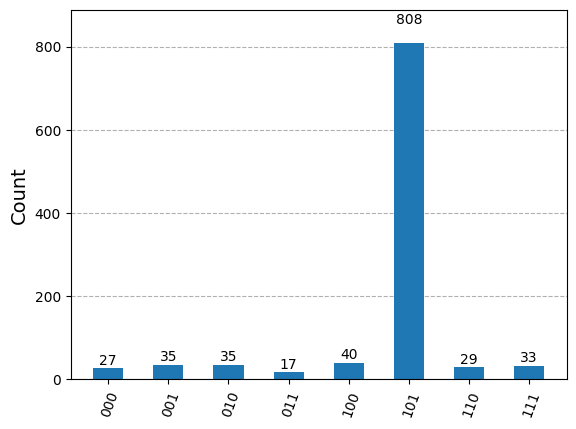

In [12]:
sim= AerSimulator()
target= "101" #example target
qc= grover(target)

transpiled_qc= transpile(qc, sim)
job= sim.run(transpiled_qc)
result= job.result()
counts= result.get_counts()
print(counts)

plot_histogram(counts)

In [ ]:
sampler= Sampler(backend)  #AerSampler for simulating noise-free locally
pm = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=0)


Counter({'101': 1995, '110': 431, '111': 373, '011': 344, '001': 320, '010': 281, '100': 206, '000': 146})


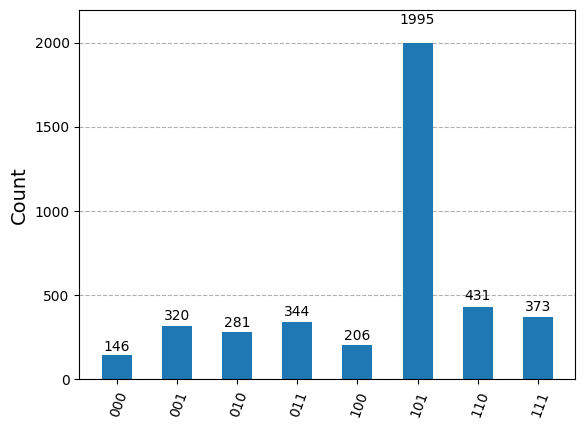

In [29]:
#run on actual hardware
isa_qc= pm.run(qc)
result= sampler.run([isa_qc]).result()
print(result)
#counts= result.quasi_dists[0].binary_probabilities()
#print(counts)
#plot_histogram(counts)
pub_result = result[0]

#access the bitstrings from the 'c' attribute of the DataBin
bitstrings_data = pub_result.data.c

#convert the bitstrings to a list of binary strings by accessing the internal array
binary_strings = [bin(int.from_bytes(x, byteorder='big'))[2:].zfill(bitstrings_data.num_bits) for x in bitstrings_data._array]

#count the occurrences of each binary string
counts = Counter(binary_strings)

print(counts)
plot_histogram(counts)

In [9]:
#generalisation for multiple solutions
#number of solutions 'k' are known in advance

In [10]:
def multi_solution_oracle(solutions: list[str]):
    n= len(solutions[0])
    qc= QuantumCircuit(n)

    for sol in solutions:
        qc_i= QuantumCircuit(n)
        #apply X where bit is '0'
        for i, bit in enumerate(sol):
            if bit == '0':
                qc_i.x(i)

        #MCZ gate
        qc_i.h(n - 1)
        qc_i.mcx(list(range(n - 1)), n - 1)
        qc_i.h(n - 1)

        for i, bit in enumerate(sol):
            if bit == '0':
                qc_i.x(i)

        qc.compose(qc_i, inplace=True)

    return qc


In [11]:
def grover_multi(solutions: list[str], iterations=None):
    n= len(solutions[0])
    N= 2**n
    k= len(solutions)

    if iterations is None:
        iterations = int(np.floor(np.pi/4 * np.sqrt(N / k))) #optimal number of iterations

    qc= QuantumCircuit(n, n)

    #initial superposition
    qc.h(range(n))

    oracle_circuit= multi_solution_oracle(solutions)
    diffuser_circuit= diffuser(n)

    for _ in range(iterations):
        qc.append(oracle_circuit, range(n))
        qc.append(diffuser_circuit, range(n))

    #measurement
    qc.measure(range(n), range(n))

    return qc


{'011': 504, '101': 520}


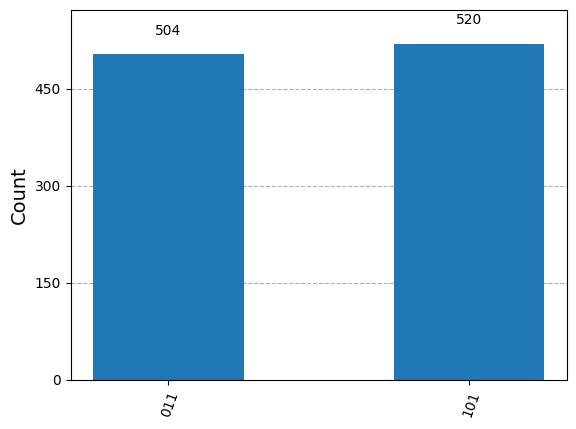

In [13]:
solutions = ['101', '110']  #example with 2 solutions
grover_circ = grover_multi(solutions)

transpiled_qc= transpile(grover_circ, sim)
job= sim.run(transpiled_qc)
result= job.result()
counts= result.get_counts()
print(counts)

plot_histogram(counts)

Counter({'101': 1666, '011': 1035, '001': 299, '111': 283, '100': 242, '110': 203, '010': 188, '000': 180})


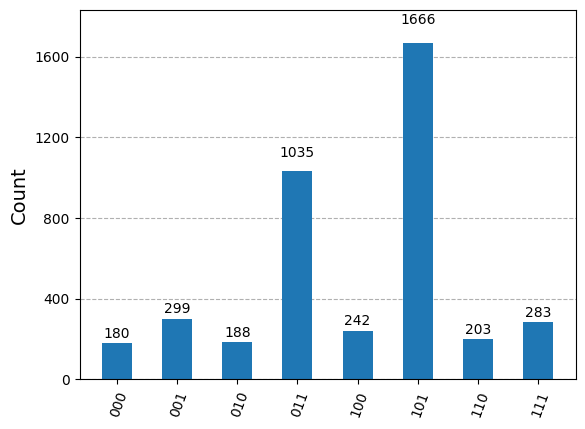

In [32]:
#run on actual hardware
isa_grover= pm.run(grover_circ)
result= sampler.run([isa_grover]).result()
pub_result = result[0]

#access the bitstrings from the 'c' attribute of the DataBin
bitstrings_data = pub_result.data.c

#convert the bitstrings to a list of binary strings by accessing the internal array
binary_strings = [bin(int.from_bytes(x, byteorder='big'))[2:].zfill(bitstrings_data.num_bits) for x in bitstrings_data._array]

#count the occurrences of each binary string
counts = Counter(binary_strings)

print(counts)
plot_histogram(counts)